/var/folders/t3/xhtsf2011qndtzgvjdgdnylw0000gn/T/ipykernel_68981/3535233844.py:26: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


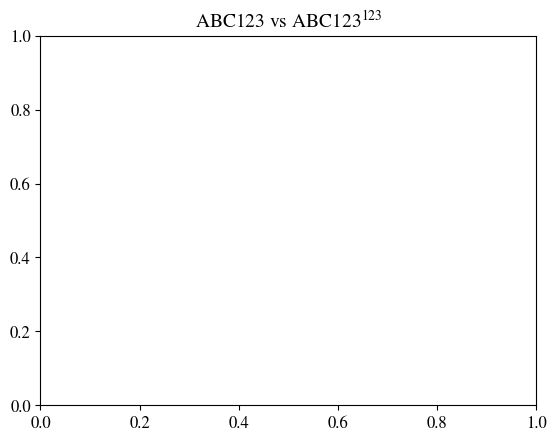

In [1]:
import torch
import os
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D
from matplotlib import rc
import matplotlib
from math import sqrt

import json
%matplotlib inline

rc('font', family='serif', style='normal', variant='normal', weight='normal', stretch='normal', size=8)
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
matplotlib.style.use('default')
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}\usepackage{bm}"]


In [2]:
exp_dir = "../experiments/experiment_v1/"
max_hv_dir = "./max_hvs/"

In [3]:
from matplotlib.ticker import FormatStrFormatter

plot_args = {
    "expectation_nparego": {"label": "Expectation qParEGO", "color": "tab:olive"},
    "expectation_nehvi_rff": {"label": "Expectation NEHVI-RFF", "color": "tab:cyan"},
    "ref_mvar_nehvi_rff": {"label": "MVaR NEHVI-RFF", "color": "tab:pink"},
    "ref_ch-var-nei": {"label": "MARS-NEI", "color": "tab:red"},
    # "ch-var-ucb": {"label": "MARS-UCB", "color": "tab:cyan", "ls": ":"},
    "ref_ch-var-ts": {"label": "MARS-TS", "color": "tab:brown", "ls": (0, (3, 5, 1, 5, 1, 5))},
}
labels = list(plot_args.keys())
N_REPS = 20
verbose = False
shade_alpha = 0.1
plot_regret = True
plot_log = True
default_figsize = (5, 4)
legend_cols = 1


def plot(problem, basename: str = None, max_hv_name: str = None, title=None, marker=None, fig=None, ax=None):
    basename = basename or problem
    if plot_regret:
        if max_hv_name is None:
            max_hv_name = problem
        max_hv = torch.load(
            os.path.join(max_hv_dir, f"{max_hv_name}.pt")
        )["max_hv"]
    min_iter = 200 if problem == "penicillin" else 100
    final_regrets = {}
    final_sem = {}
    for n_w in [8, 16, 32, 64, 96, 128]:
        agg_results = {}
        for label in labels:
            for seed in range(N_REPS):
                p_name = f"{basename}_{n_w}" if n_w != 32 else problem
                path = os.path.join(exp_dir, p_name, label, f"{str(seed).zfill(4)}_{label}.pt")
                try:
                    res = torch.load(path, map_location="cpu")
                except (FileNotFoundError, EOFError):
                    if verbose:
                        print(f"No file found, skipping: {os.path.basename(path)}!")
                    continue
                if label not in agg_results:
                    agg_results[label] = {k: (v.unsqueeze(0) if torch.is_tensor(v) else v) for k,v in res.items()}
                else:
                    label_res = agg_results[label]
                    for k,v in res.items():
                        if torch.is_tensor(v):
                            if v.shape[0] != label_res[k].shape[1]:
                                if v.shape[0] < min_iter:
                                    if verbose:
                                        print(f"Insufficient iterations, skipping: {os.path.basename(path)}!")
                                    break
                                # partial result
                                max_iter = min(label_res[k].shape[1], v.shape[0])
                                label_res[k] = label_res[k][:, :max_iter]
                                v = v[:max_iter]
                            label_res[k] = torch.cat([label_res[k], v.unsqueeze(0)], dim=0)
        final_regrets[n_w] = {}
        final_sem[n_w] = {}
        for label in labels:
            try:
                res = agg_results[label]
            except KeyError:
                continue
            hvs = res["all_mvar_hvs"]
            if hvs.shape[0] < 10:
                continue
            hv_mean = hvs.mean(dim=0)
            hv_sem = hvs.std(dim=0)/sqrt(hvs.shape[0])
            if plot_regret:
                hv_mean = max_hv - hv_mean
            final_regrets[n_w][label] = hv_mean[-1]
            final_sem[n_w][label] = hv_sem[-1]
            mean_time = res['wall_time'].mean(dim=0)[-1]
            sem_time = res['wall_time'].std(dim=0)[-1] / sqrt(hvs.shape[0]) * 2
            print(f"N_w: {n_w}, Label: {label}, num replications: {hvs.shape[0]}, time: {mean_time}, +- {sem_time}")

    using_existing_fig = fig is not None
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=default_figsize)
    for label in labels:
        xs = []
        ys = []
        sems = []
        for n_w in [8, 16, 32, 64, 96, 128]:
            try:
                ys.append(final_regrets[n_w][label].item())
                sems.append(2 * final_sem[n_w][label].item())
                xs.append(n_w)
            except KeyError:
                continue
        print(xs, ys, sems)
        ax.errorbar(xs, ys, yerr=sems, label=plot_args[label]["label"], capsize=5)
    if title:
        ax.set_title(title)
    else:
        ax.set_title(problem)
    # if plot_log:
    #     ax.set_yscale("log")
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.legend(loc=1, ncol=legend_cols)
    fig.tight_layout()
    ax.set_ylabel("Final MVAR HV Regret")
    ax.set_xlabel("$n_\\xi$")
    if title:
        plt.savefig(f"plots/{problem}_effect_of_n_xi.pdf", dpi=300, bbox_inches='tight')


N_w: 8, Label: expectation_nparego, num replications: 20, time: 1672.8757838487625, +- 197.36520911255838
N_w: 8, Label: expectation_nehvi_rff, num replications: 20, time: 605.4769002795219, +- 108.95942509559941
N_w: 8, Label: ref_mvar_nehvi_rff, num replications: 20, time: 353.8996618270874, +- 44.65384680094063
N_w: 8, Label: ref_ch-var-nei, num replications: 20, time: 936.5495630383491, +- 73.56365980288436
N_w: 8, Label: ref_ch-var-ts, num replications: 20, time: 448.2425335764885, +- 15.745195354973998
N_w: 16, Label: expectation_nparego, num replications: 20, time: 1809.0187091946602, +- 359.29720019511007
N_w: 16, Label: expectation_nehvi_rff, num replications: 20, time: 575.7770926594734, +- 93.24792745513132
N_w: 16, Label: ref_mvar_nehvi_rff, num replications: 20, time: 302.16722378730776, +- 38.28155785491821
N_w: 16, Label: ref_ch-var-nei, num replications: 20, time: 1194.2181841611862, +- 267.08816449893965
N_w: 16, Label: ref_ch-var-ts, num replications: 20, time: 706.17

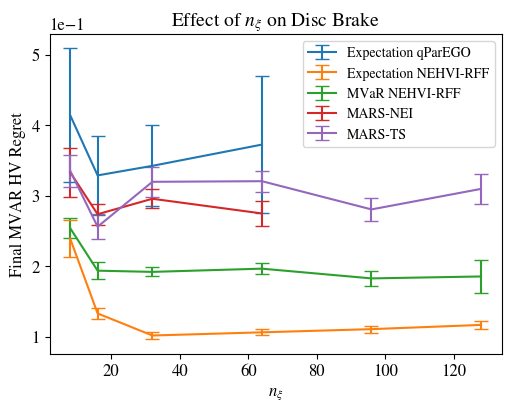

In [4]:
plot("disc_brake", title="Effect of $n_\\xi$ on Disc Brake")

N_w: 8, Label: expectation_nparego, num replications: 20, time: 1028.2070373773574, +- 101.15188422805005
N_w: 8, Label: expectation_nehvi_rff, num replications: 20, time: 715.1456823587417, +- 107.0256992369486
N_w: 8, Label: ref_mvar_nehvi_rff, num replications: 20, time: 680.8202954530716, +- 76.30431335128658
N_w: 8, Label: ref_ch-var-nei, num replications: 20, time: 746.7282215356827, +- 51.17968830059938
N_w: 8, Label: ref_ch-var-ts, num replications: 20, time: 350.7453264951706, +- 41.50717327112395
N_w: 16, Label: expectation_nparego, num replications: 20, time: 1016.0334319114685, +- 70.08409054791464
N_w: 16, Label: expectation_nehvi_rff, num replications: 20, time: 632.8432005643845, +- 61.32167470330461
N_w: 16, Label: ref_mvar_nehvi_rff, num replications: 20, time: 837.7995553612709, +- 129.38168744582663
N_w: 16, Label: ref_ch-var-nei, num replications: 20, time: 755.8769744992256, +- 65.88111699412295
N_w: 16, Label: ref_ch-var-ts, num replications: 20, time: 371.8162415

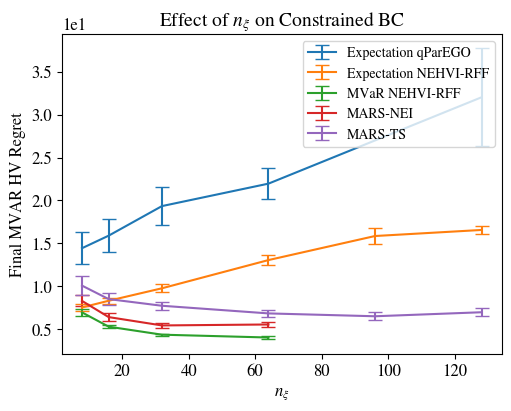

In [5]:
plot("bc_v2", "bc", title="Effect of $n_\\xi$ on Constrained BC")

